# 신용카드 사기 검출

In [1]:
# 라이브러리 불러오기

'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
# 데이터 셋 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)

In [3]:
# 평가 함수 정의

In [4]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [5]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [6]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

# 주성분 분석(PCA)

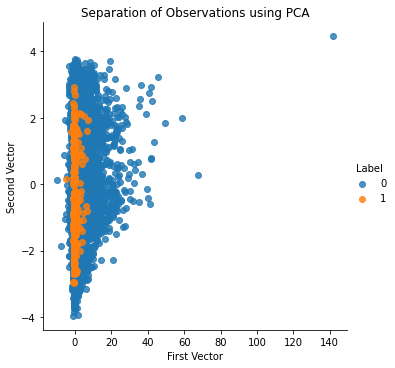

In [8]:
# 30개 주성분
from sklearn.decomposition import PCA

n_components = 30
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

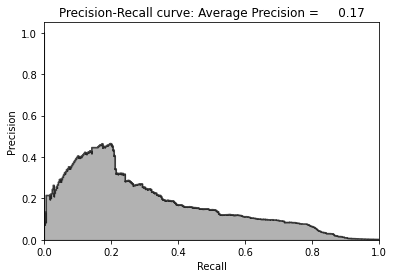

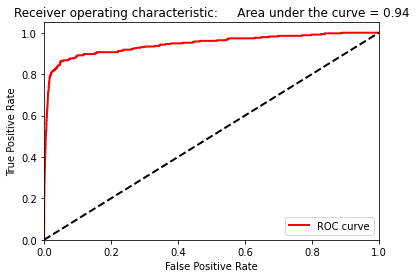

In [9]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

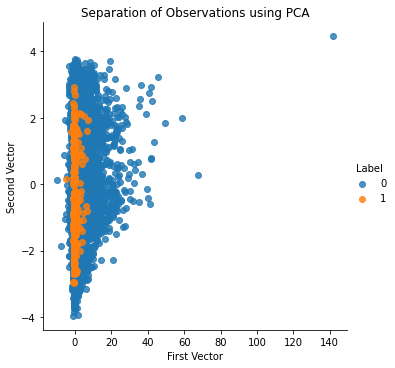

In [10]:
# 27개 주성분
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

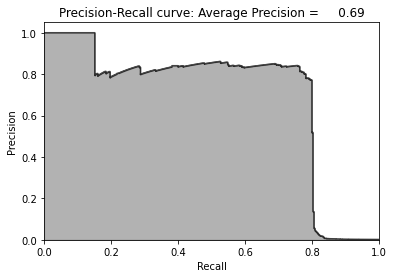

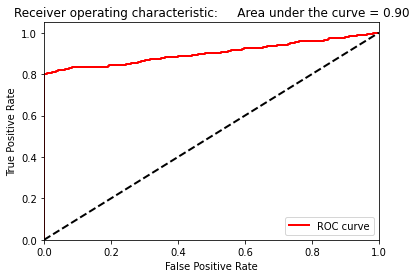

In [11]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [12]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.75
Recall:  0.8
Fraud Caught out of 330 Cases: 264


# 희소 PCA(SparsePCA)

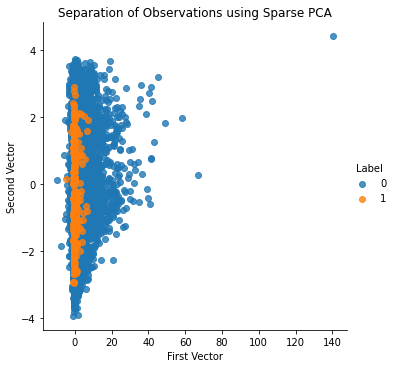

In [13]:
# 희소 PCA
from sklearn.decomposition import SparsePCA

n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

# sparsePCA = SparsePCA(n_components=n_components, \
#                alpha=alpha, random_state=random_state, n_jobs=n_jobs)

##** 수정 사항 : normalize_components='deprecated' 옵션을 설정하면 경고메세지가 삭제됨 components 정규화는 무조건 실행 되기 때문에 의미 없는 옵션임
sparsePCA = SparsePCA(n_components=n_components, \
                alpha=alpha, random_state=random_state, n_jobs=n_jobs,normalize_components='deprecated')

sparsePCA.fit(X_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

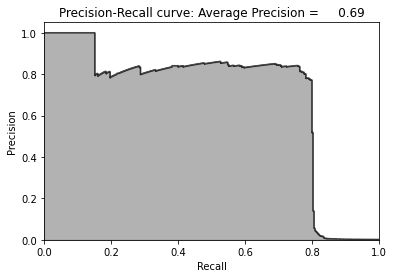

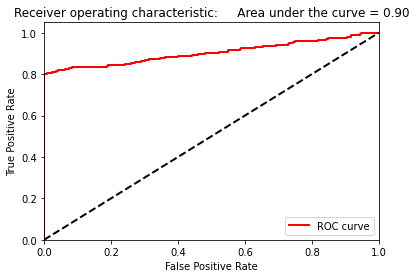

In [14]:
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA). \
    dot(sparsePCA.components_) + np.array(X_train.mean(axis=0))
X_train_sparsePCA_inverse = \
    pd.DataFrame(data=X_train_sparsePCA_inverse, index=X_train.index)

anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

# 커널 PCA(KernelPCA)

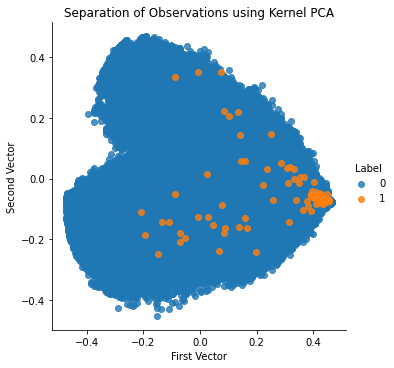

In [15]:
# 커널 PCA
from sklearn.decomposition import KernelPCA

n_components = 27
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train.iloc[:2000])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

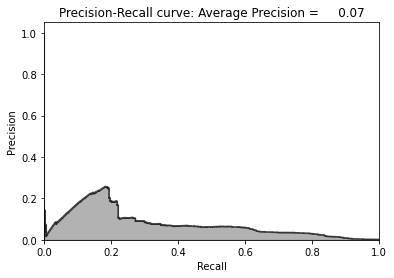

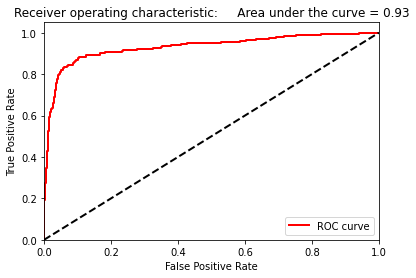

In [16]:
anomalyScoresKernelPCA = anomalyScores(X_train, X_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoresKernelPCA, True)

# 가우시안 랜덤 투영(GaussianRandomProjection)

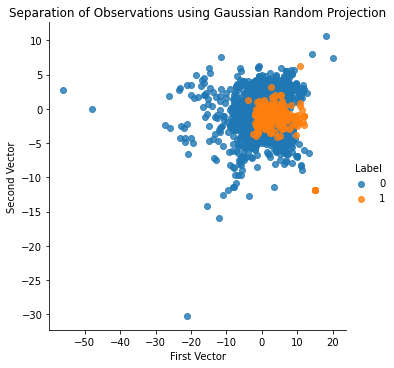

In [17]:
# 가우시안 랜덤 투영
from sklearn.random_projection import GaussianRandomProjection

n_components = 27
eps = None
random_state = 2018

GRP = GaussianRandomProjection(n_components=n_components, \
                               eps=eps, random_state=random_state)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X_train.index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

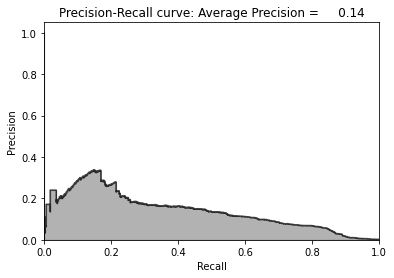

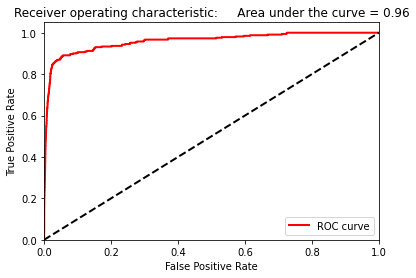

In [18]:
X_train_GRP_inverse = np.array(X_train_GRP).dot(GRP.components_)
X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse, \
                                   index=X_train.index)

anomalyScoresGRP = anomalyScores(X_train, X_train_GRP_inverse)
preds = plotResults(y_train, anomalyScoresGRP, True)

# 희소 랜덤 투영(SparseRandomProjection)

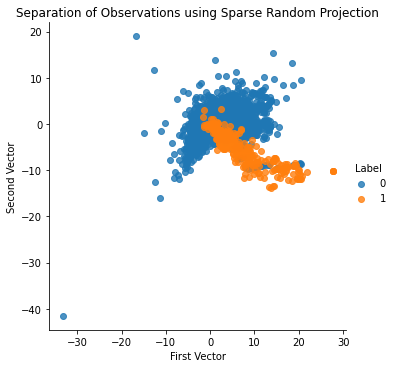

In [19]:
# 희소 랜덤 투영

from sklearn.random_projection import SparseRandomProjection

n_components = 27
density = 'auto'
eps = .01
dense_output = True
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, \
        density=density, eps=eps, dense_output=dense_output, \
                                random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

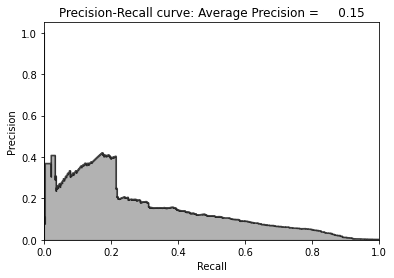

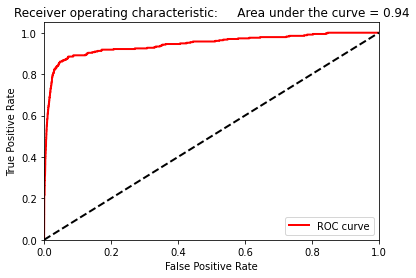

In [20]:
X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

anomalyScoresSRP = anomalyScores(X_train, X_train_SRP_inverse)
plotResults(y_train, anomalyScoresSRP)

# 미니-배치 사전 학습(MiniBatchDictionaryLearning)

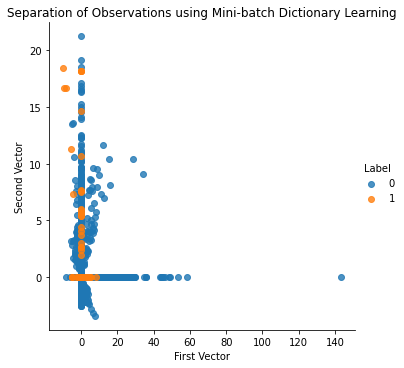

In [33]:
# 미니-배치 사전 학습
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 28
alpha = 1
batch_size = 200
n_iter = 10
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning( \
    n_components=n_components, alpha=alpha, batch_size=batch_size, \
    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(X_train)
X_train_miniBatchDictLearning = \
    miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = \
    pd.DataFrame(data=X_train_miniBatchDictLearning, index=X_train.index)

scatterPlot(X_train_miniBatchDictLearning, y_train, \
            "Mini-batch Dictionary Learning")

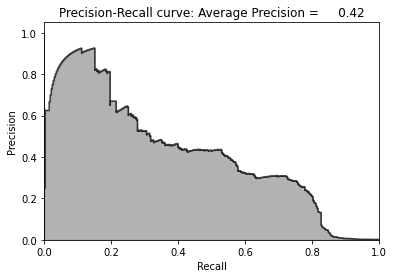

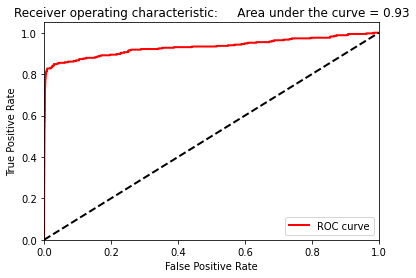

In [22]:
X_train_miniBatchDictLearning_inverse = \
    np.array(X_train_miniBatchDictLearning). \
    dot(miniBatchDictLearning.components_)

X_train_miniBatchDictLearning_inverse = \
    pd.DataFrame(data=X_train_miniBatchDictLearning_inverse, \
                 index=X_train.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(X_train, \
    X_train_miniBatchDictLearning_inverse)
preds = plotResults(y_train, anomalyScoresMiniBatchDictLearning, True)

# 독립 성분 분석(FastICA)

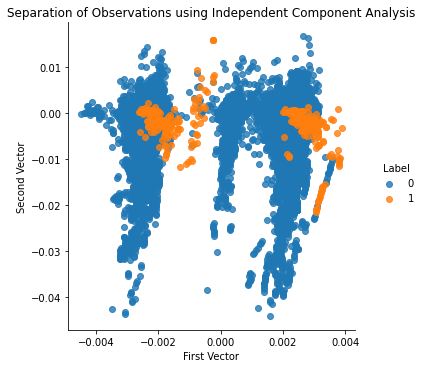

In [23]:
# 독립 성분 분석

from sklearn.decomposition import FastICA

n_components = 27
algorithm = 'parallel'
whiten = True
max_iter = 200
random_state = 2018

fastICA = FastICA(n_components=n_components, \
    algorithm=algorithm, whiten=whiten, max_iter=max_iter, \
    random_state=random_state)

X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=X_train.index)

X_train_fastICA_inverse = fastICA.inverse_transform(X_train_fastICA)
X_train_fastICA_inverse = pd.DataFrame(data=X_train_fastICA_inverse, \
                                       index=X_train.index)

scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")

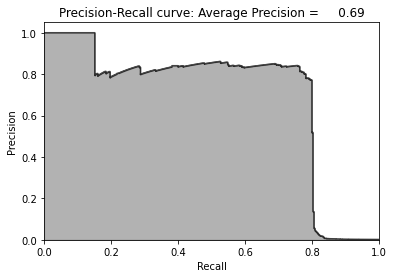

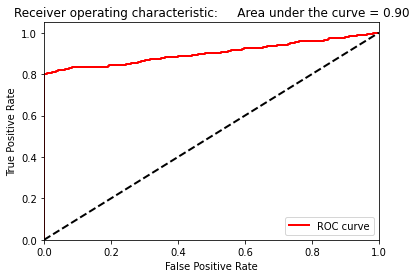

In [24]:
anomalyScoresFastICA = anomalyScores(X_train, X_train_fastICA_inverse)
plotResults(y_train, anomalyScoresFastICA)

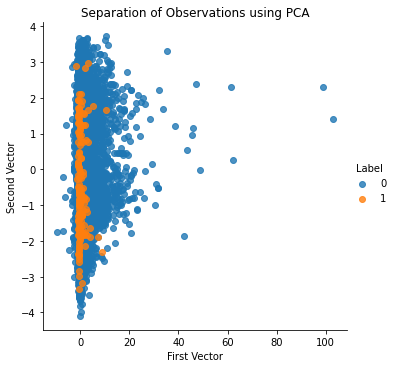

In [25]:
# 테스트 셋에 PCA 적용
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, \
                                  index=X_test.index)

scatterPlot(X_test_PCA, y_test, "PCA")

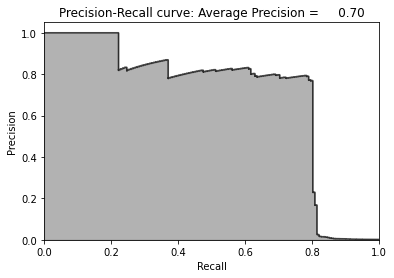

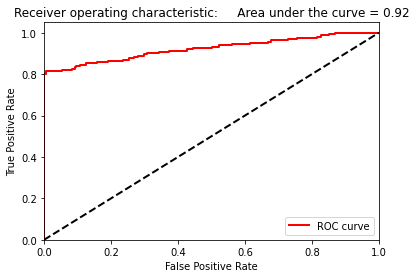

In [26]:
anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScoresPCA, True)

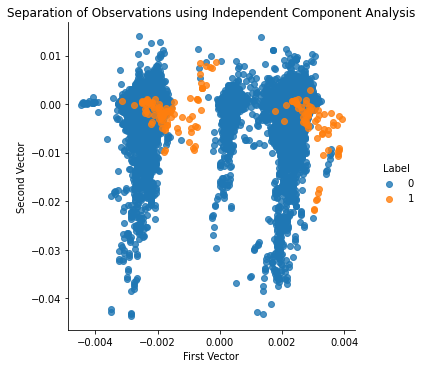

In [27]:
# 테스트 셋에 독립 성분 분석 적용
X_test_fastICA = fastICA.transform(X_test)
X_test_fastICA = pd.DataFrame(data=X_test_fastICA, index=X_test.index)

X_test_fastICA_inverse = fastICA.inverse_transform(X_test_fastICA)
X_test_fastICA_inverse = pd.DataFrame(data=X_test_fastICA_inverse, \
                                      index=X_test.index)

scatterPlot(X_test_fastICA, y_test, "Independent Component Analysis")

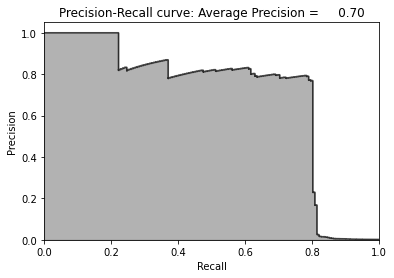

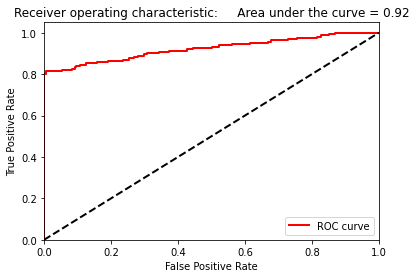

In [28]:
anomalyScoresFastICA = anomalyScores(X_test, X_test_fastICA_inverse)
plotResults(y_test, anomalyScoresFastICA)

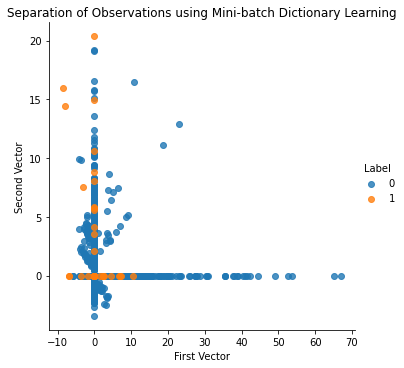

In [29]:
X_test_miniBatchDictLearning = miniBatchDictLearning.transform(X_test)
X_test_miniBatchDictLearning = \
    pd.DataFrame(data=X_test_miniBatchDictLearning, index=X_test.index)

scatterPlot(X_test_miniBatchDictLearning, y_test, \
            "Mini-batch Dictionary Learning")

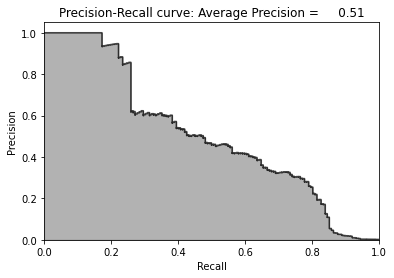

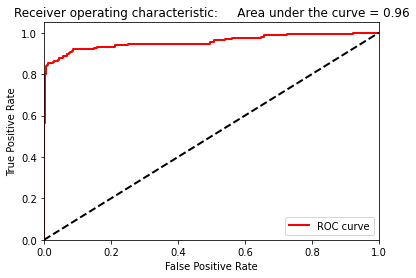

In [30]:
X_test_miniBatchDictLearning_inverse = \
    np.array(X_test_miniBatchDictLearning). \
    dot(miniBatchDictLearning.components_)

X_test_miniBatchDictLearning_inverse = \
    pd.DataFrame(data=X_test_miniBatchDictLearning_inverse, \
                 index=X_test.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(X_test, \
    X_test_miniBatchDictLearning_inverse)
preds = plotResults(y_test, anomalyScoresMiniBatchDictLearning, True)